# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

#### Colab

*The following cells are optional for colab users only*

* Use the first 2 cells to establish connection with your Google Drive if needed and set the current working directory to the folder of your choice, where the project is located on your Google Drive.
* Next you may either upload dog and human datasets there manually or use the subsequent cells to download and unzip the datasets while running the notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/DogBreedProject')

In [ ]:
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages

In [ ]:
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
# !unzip lfw

#### Libraries, and additional functions

In [ ]:
# Load libraries
import numpy as np
from glob import glob
import re
from tqdm import tqdm
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchsummary import summary

# the following import is required for training to be robust to truncated images
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

device = (torch.device('cuda') if torch.cuda.is_available()
                               else torch.device('cpu'))
print(f'Training on device {device}.')

Training on device cuda.


In [ ]:
def print_now(output_text:str='{}', t_format:str="%Y/%m/%d %H:%M:%S"):
    """ 
    Prints current date and time. 
    Allows to adjust output_text format and timestamp format.
    """
    now = datetime.now().strftime(t_format)
    output_text = output_text.format(now)
    print(output_text)

In [ ]:
def display_img_from_path(img_path:str, title:bool=True, prediction:str=None, descr:str=None):
    """ 
    Displays image from img_path and prints file name as image title underneath. 
    If prediction specified, prints prediction underneath the title for comparison.

    Args:
        img_path: path to image file
        title: if True, prints image title from image file name (defaul=True).
        prediction: if provided, prints the content as image prediction (default=None). 
        descr: if provided, prints the image description (default=None). 
    """
    
    # read image from specified file and display
    img = imread(img_path)
    plt.figure()
    plt.imshow(img)
    plt.show()
    
    # display file name as image title
    if title:
        title_ = re.findall('([a-zA-Z_-]+)\d+.jpg$', img_path)[0].replace('_', ' ').strip()
        print(f'Name/breed: {title_}')
    
    # display prediction if provided
    if prediction:
        print(f'Predicted:  {prediction}')
    
    if descr:
        print(descr)
    
    print(34*'-')

#### Import datasets

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [ ]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files_train = np.array(glob("dogImages/train/*/*"))
dog_files_valid = np.array(glob("dogImages/valid/*/*"))
dog_files_test = np.array(glob("dogImages/test/*/*"))

# print number of images in each dataset
print(f'There are {len(human_files)} total human images.')
print('There are {} total dog images.\n'.format(
       len(dog_files_train) + len(dog_files_valid) + len(dog_files_test)
       ))

print(f'There are {len(dog_files_train)} of training dog images.')
print(f'There are {len(dog_files_valid)} of validation dog images.')
print(f'There are {len(dog_files_test)} of test dog images.')

There are 13233 total human images.
There are 8351 total dog images.

There are 6680 of training dog images.
There are 835 of validation dog images.
There are 836 of test dog images.


#### Datasets overview
In both, human and dog datasets, there are images which might be misleading for a learning model. The images tend to be in various shapes and quality.

There are human images that contain more than a single person. For a model this might lead to a conclusion that a human have multiple heads.

Dog images may contain humans, dressed dogs or more than one dog which is not necessarily the same breed. This adds extra noise in the training process.

In [ ]:
# Image examples
with_people = ['00232', '00297']
dressed = ['00044', '00530']
mixed = ['00217', '00532']
multi_human = ['Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg',
               'Abdulaziz_Kamilov/Abdulaziz_Kamilov_0001.jpg']

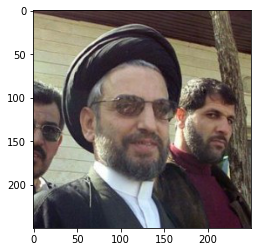

Name/breed: Abdel Aziz Al-Hakim
----------------------------------


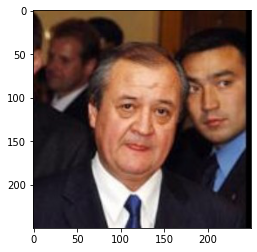

Name/breed: Abdulaziz Kamilov
----------------------------------


In [ ]:
for file_path in multi_human:
    display_img_from_path(os.path.join('lfw',file_path))

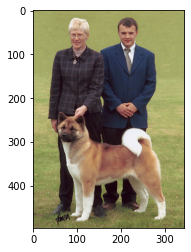

Name/breed: Akita
----------------------------------


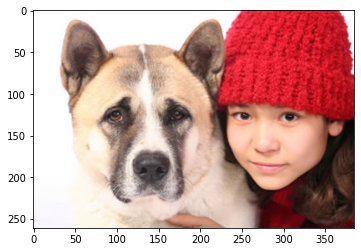

Name/breed: Akita
----------------------------------


In [ ]:
for file_path in dog_files_train[:500]:
    for i in with_people:
        if i in file_path:
            display_img_from_path(file_path)

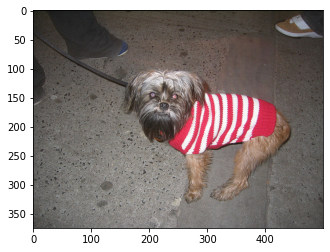

Name/breed: Affenpinscher
----------------------------------


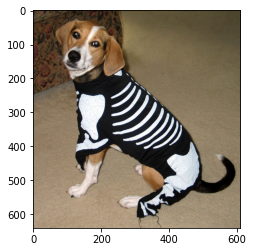

Name/breed: American foxhound
----------------------------------


In [ ]:
for file_path in dog_files_train[:500]:
    for i in dressed:
        if i in file_path:
            display_img_from_path(file_path)

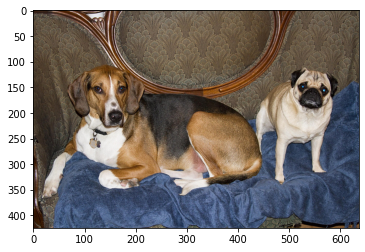

Name/breed: American foxhound
----------------------------------


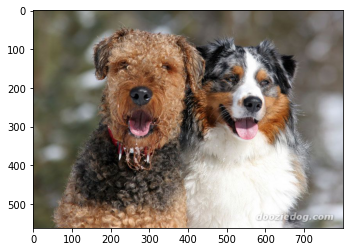

Name/breed: Airedale terrier
----------------------------------


In [ ]:
for file_path in dog_files_train[:500]:
    for i in mixed:
        if i in file_path:
            display_img_from_path(file_path)

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


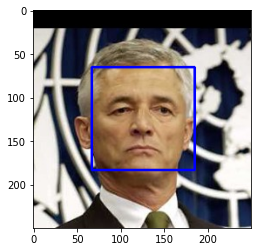

In [ ]:
def display_face_detector(img_path):
    """
    Read image from img_path and use face_detection to recognize faces.
    Print the number of faces detected and display image with the faces marked. 
    """
    # load color (BGR) image
    img = cv2.imread(img_path)

    # convert BGR image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(img_gray)

    # print number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.figure()
    plt.imshow(cv_rgb)
    plt.show()


# load color (BGR) image
display_face_detector(human_files[87])

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [ ]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    """
    Read image and use face_cascade to detect faces.
    
    Returns:
        bool: if any faces detected in image.
    """
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

* `face_detector` detected faces in 99% images. The pre-trained `frontalface` detector failed on a dynamic image from sports event, where the facial expression looks different than a standard portrait. In the displayed image below the eyeballs seems black, where eyes most likely are the key element in facial recognition. 
* at the same time the 'face_detector' have detected humans in 9% of images. This could be either a correctly detected human present with their dog or for some reason a dog incorrectly described as human. Additionally in few cases a random object got marked as human face such as dog's nose.

In [ ]:
human_files_short = human_files[:100]
dog_files_short = dog_files_train[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_files_with_no_humans = []
dog_files_with_humans = []

for i in tqdm(range(100)):
    # test human file 
    human_files_check = face_detector(human_files_short[i])
    if not human_files_check:
        human_files_with_no_humans.append(human_files_short[i])

for i in tqdm(range(100)):
    # test dog file
    dog_files_check = face_detector(dog_files_short[i])
    if dog_files_check:
        dog_files_with_humans.append(dog_files_short[i])
        

print(f"\nCounted {len(human_files_with_no_humans)} non-detected human faces in 100 human images")
print(f"Counted {len(dog_files_with_humans)} human faces in 100 dog images")

100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


Counted 1 non-detected human faces in 100 human images
Counted 9 human faces in 100 dog images


Failed to detect human face:
Number of faces detected: 0


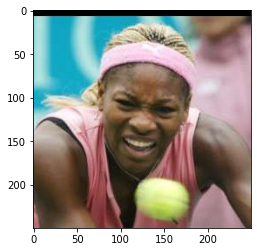

In [ ]:
print("Failed to detect human face:")

for file_path in human_files_with_no_humans:
    display_face_detector(file_path)

Incorrectly detected human face:
Number of faces detected: 1


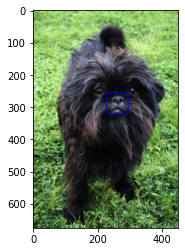

Number of faces detected: 1


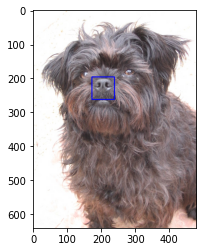

In [ ]:
print("Incorrectly detected human face:")

for file_path in dog_files_with_humans[:2]:
    display_face_detector(file_path)

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [ ]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
VGG16 = VGG16.to(device=device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [ ]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Import image from img_path in PIL format
    img = Image.open(img_path)
    
    # Compose image transformations in pipeline
    transform_pipeline = transforms.Compose(
        [transforms.Resize(256),  # resizes input img to common size
         transforms.ToTensor(),  # transforms PIL img into tensor
         transforms.Normalize(mean=(0.485, 0.456, 0.406),
                              std=(0.229, 0.224, 0.225))  # normalizes img channels into [-1,1] range
        ])  
    
    # transform img using the pipeline
    img_tensor = transform_pipeline(img)
    # Insert dimension 1 at 0 pozition
    img_tensor = img_tensor.unsqueeze(0)
    
    # move img_tensor to GPU
    img_tensor = img_tensor.to(device)
        
    # use VGG16 model to predict image class
    prediction = VGG16(img_tensor)
    prediction = prediction.argmax()
    
    return prediction # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [ ]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    img_prediction_value = VGG16_predict(img_path)
    result = True if (img_prediction_value > 150 and img_prediction_value < 269) else False
    
    return result # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
* 1% of `human_files_short` have a detected dog.
* 100% of `dog_files_short` have a detected dog.

In [ ]:
# ### TODO: Test the performance of the dog_detector function
# ### on the images in human_files_short and dog_files_short.

human_files_with_dogs = []
dog_files_with_no_dogs = []

for i in tqdm(range(100)):
    # test human file 
    human_files_check = dog_detector(human_files_short[i])
    if human_files_check:
        human_files_with_dogs.append(human_files_short[i])

for i in tqdm(range(100)):
    # test dog file
    dog_files_check = dog_detector(dog_files_short[i])
    if not dog_files_check:
        dog_files_with_no_dogs.append(dog_files_short[i])

print(f'\n\nNumber of human files with dogs: {len(human_files_with_dogs)}.')
# print(f'Affected files: {human_files_with_dogs}')
print(f'Number of dog files without dogs detected: {len(dog_files_with_no_dogs)}.')
# print(f'Affected files: {dog_files_with_no_dogs}')

100%|██████████| 100/100 [00:02<00:00, 46.69it/s]



Number of human files with dogs: 0.
Number of dog files without dogs detected: 0.


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [ ]:
class DogImageFolder(ImageFolder):
    """ 
    ImageFolder type class adjusted for dogImages dataset. 
    """
    def __init__(self, root:str, transform = None):
        super().__init__(root, transform)

        # Update classes list by removing an index from a single class string 
        self.classes = [c.split('.')[-1].replace('_', ' ') 
                        for c in self.classes]

In [ ]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
data_dir = 'dogImages'
TRAIN = 'train'
VAL = 'valid'
TEST = 'test'

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
input_shape = 224
batch_size = 32
scale = 256

train_transforms = transforms.Compose([
        transforms.RandomRotation(degrees=30),
        transforms.RandomResizedCrop(input_shape),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
test_transforms = transforms.Compose([
        transforms.Resize(scale),
        transforms.CenterCrop(input_shape),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])

dog_train_dataset = DogImageFolder(os.path.join('dogImages', 'train'), transform=train_transforms)
dog_valid_dataset = DogImageFolder(os.path.join('dogImages', 'valid'), transform=test_transforms) 
dog_test_dataset = DogImageFolder(os.path.join('dogImages', 'test'), transform=test_transforms)


train_loader = torch.utils.data.DataLoader(dog_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(dog_valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(dog_test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

print(f"Loaded {len(dog_train_dataset)} images for training.")
print(f"Loaded {len(dog_valid_dataset)} images for validation.")
print(f"Loaded {len(dog_test_dataset)} images for test.")

dog_class_names = dog_train_dataset.classes    
print(f"Classes: {dog_class_names[:10]}")

Loaded 6680 images for training.
Loaded 835 images for validation.
Loaded 836 images for test.
Classes: ['Affenpinscher', 'Afghan hound', 'Airedale terrier', 'Akita', 'Alaskan malamute', 'American eskimo dog', 'American foxhound', 'American staffordshire terrier', 'American water spaniel', 'Anatolian shepherd dog']


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
* For training purpose a `RandomResizeCrop()` is used to resize input images.
As mentioned here https://paperswithcode.com/method/randomresizedcrop
_`RandomResizedCrop()` is a type of image data augmentation where a crop of random size of the original size and a random aspect ratio of the original aspect ratio is made. This crop is finally resized to given size._
* For test and validation input image is rescaled first with `Resize(size)` for it's shorter dimension to match the `size` and then it is CenterCrop() is used to crop to 224x224.
* Additionally for the training dataset `RandomVerticalFlip()` and `RandomHorizontalFlip()` are in use to generate more random samples out of input dataset.
* All images after converting to tensor are transformed with `Normalize()` with defined `mean` and std values. The used values are definead based on PyTorch Normalize values: 
https://pytorch.org/docs/stable/torchvision/transforms.html#scriptable-transforms \
(The values should be real mean and std of used dataset. How to calculate those values for a completely different dataset?)



### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [ ]:
# MODIFIED ORIGIN MODEL

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.features = nn.Sequential(
            # 1st 2D convolution layer
            nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Defining another 2D convolution layer
            nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Defining another 2D convolution layer
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Dropout(p=0.5),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.Dropout(p=0.3),
            nn.Linear(512, 133),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        ## Define forward behavior
        out = self.features(x)
        out = out.reshape(out.size(0),-1)
        out = self.classifier(out)
        
        return out

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move model to GPU if CUDA is available
model_scratch = model_scratch.to(device=device)

In [ ]:
# Print model details
summary(model_scratch, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]           1,216
              ReLU-2         [-1, 16, 112, 112]               0
         MaxPool2d-3           [-1, 16, 56, 56]               0
            Conv2d-4           [-1, 32, 57, 57]           2,080
              ReLU-5           [-1, 32, 57, 57]               0
         MaxPool2d-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 64, 29, 29]           8,256
              ReLU-8           [-1, 64, 29, 29]               0
         MaxPool2d-9           [-1, 64, 14, 14]               0
          Dropout-10           [-1, 64, 14, 14]               0
        AvgPool2d-11             [-1, 64, 7, 7]               0
           Linear-12                  [-1, 512]       1,606,144
          Dropout-13                  [-1, 512]               0
           Linear-14                  [

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

The above structure was achieve based on experimenting with simple CNN architecture examples, found in resourses such as Deep Learning literature, online tutorials or other github profiles. Initially each model was trained with 5 `epochs` and evaluated. Test accuracy varied with mostly dissapointing result while in few cases the model didn't improve during training. 

* The basic structure for convolution steps is common (convolution layer, activation function, max pool). Initially `kernel size`, `stride` and `padding` were equal within all convolution layers. First experimented with all values evenly. One of resources suggested to use higher values for the first convolution. 
* Different `dropout` values or lack of dropout were tested prior to linear layer.
* `Softmax` activation function was replaced with `LogSoftmax` based on the performance.
* Adding `AvgPool2d` (alt. `MaxPool2d`) prior to the first linear layer made noticable difference in the structure.
* Also tested few more convolution and linear layers but haven't found any improvement there with the tested parameters.

_Note: The following details are not directly related to model structure however were included in model trails._ 

The best architectures were tested against `Adam` and `SGD` optimizers at `lr=1e-3` and `lr=3e-3`. The second learning rate value was suggested by one of the industry literature, but didn't lead to any improvement.

Various data transformers also affected the performance: 
* `RandomResizedCrop` resulted in higher accuracy than combination of `Resize` with `RandomCrop` or `CenterCrop` for the training dataset. 
* `ColorJitter` and `RandomGrayscale` didn't seem to have positive effect either, at least not at the combination used.

DataLoader's `batch_size` for training data set was tested with higher value but didn't result with an improvement as well.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [ ]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = torch.optim.Adam(model_scratch.parameters())

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [ ]:
def train(n_epochs, train_loaders, valid_loaders, model, optimizer, criterion, save_path):
    """ Returns trained model """
    # initialize tracker for monimum validation loss
    valid_loss_min = np.Inf
    
    print(f"Batch Size: {train_loader.batch_size}\n")
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loaders):
            # move to GPU
            data, target = data.to(device=device), target.to(device=device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if (batch_idx + 1) % 10 == 0:
                print_now('^^^ {} ^^^')
                print(f'Epoch:{epoch}/{n_epochs} \tBatch:{batch_idx + 1}')
                print(f'Train Loss: {train_loss:.6f}\n')
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loaders):
            # moge to GPU
            data, target = data.to(device=device), target.to(device=device)
            with torch.no_grad():
                output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print(30*'*')
        print_now()
        print('Epoch: {} \nTraining Loss: {:.6f} \nValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('\nValidation loss decreased ({:.6f} --> {:.6f}). \nSaving model...\n'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [ ]:
# model_scratch = train(20, train_loader, valid_loader, model_scratch, 
#                       optimizer_scratch, criterion_scratch, 'model_scratch.pt')

# # load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [ ]:
def test(loaders, model, criterion):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        data, target = data.to(device=device), target.to(device=device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
        if batch_idx % 5 == 0:
            print_now()
            print(f'\tEval batch_idx {batch_idx}, Test loss {test_loss}')
    print(f'\nTest Loss: {test_loss:.6f}')

    print(f'Test Accuracy: {(100 * correct / total):.0f}% ({correct:.0f}/{total:.0f})')

In [ ]:
# # call test function    
test(test_loader, model_scratch, nn.CrossEntropyLoss())

2021/01/02 02:00:59
	Eval batch_idx 0, Test loss 3.375006914138794
2021/01/02 02:01:49
	Eval batch_idx 5, Test loss 3.4651458263397217
2021/01/02 02:02:39
	Eval batch_idx 10, Test loss 3.558197259902954
2021/01/02 02:03:28
	Eval batch_idx 15, Test loss 3.565485715866089
2021/01/02 02:04:18
	Eval batch_idx 20, Test loss 3.562657117843628
2021/01/02 02:05:07
	Eval batch_idx 25, Test loss 3.5971732139587402

Test Loss: 3.614571
Test Accuracy: 14% (120/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
## TODO: Specify data loaders

# The same data loaders in use as in Step 3
# train_loader = torch.utils.data.DataLoader(dog_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# valid_loader = torch.utils.data.DataLoader(dog_valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# test_loader = torch.utils.data.DataLoader(dog_test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [ ]:
# Load model archivecture 
model_transfer = models.resnet50(pretrained=True)

# Freeze model parameters
for param in model_transfer.parameters():
    param.requires_grad = False

# Replace last layer of pretrained model to reduce the number of output features
# The output number from the last Linear layer must match number of classes.
model_transfer.fc = nn.Linear(2048, 133, bias=True)    

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
model_transfer.to(device=device)

summary(model_transfer, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

ResNet50 is a standard pretrained architecture with 50 layers in the architecture variant. It is pretrained on ImageNet dataset.

Once the model was loaded it required modification of the last layer. Initially the ouput of the linear layer was 1000, which represents the number of classes it was capable to recognize. This value was replaced with 133 representing the number of dog breeds.

The model then required additional training to update the weights for the added layer. All other layers were frozen to avoid any adjustment to the structure except the final layer. 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [ ]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = torch.optim.Adam(model_transfer.parameters())

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# train the model
# model_transfer = train(7, train_loader, valid_loader, model_transfer, 
#                        optimizer_transfer, criterion_transfer, 
#                        'model_transfer.pt')

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
# # call test function    
test(test_loader, model_transfer, criterion_transfer)

2021/01/02 02:05:14
	Eval batch_idx 0, Test loss 0.1824360191822052
2021/01/02 02:05:16
	Eval batch_idx 5, Test loss 0.5170784592628479
2021/01/02 02:05:19
	Eval batch_idx 10, Test loss 0.5643129944801331
2021/01/02 02:05:21
	Eval batch_idx 15, Test loss 0.5415138006210327
2021/01/02 02:05:23
	Eval batch_idx 20, Test loss 0.5469348430633545
2021/01/02 02:05:25
	Eval batch_idx 25, Test loss 0.5319339036941528

Test Loss: 0.540383
Test Accuracy: 81% (681/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
# class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
# This is fixed inside DogImageFolder class

def predict_breed_transfer(img_path):
    """ Load the image and return the predicted breed """

    img = Image.open(img_path)
    img_transform = transforms.Compose([transforms.Resize(258),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])

    # Unsqueeze image tensor to add 4th dimension
    img_tensor = img_transform(img).unsqueeze(0).to(device=device)

    model_transfer.eval()
    
    # Get predicted category for image
    with torch.no_grad():
        output = model_transfer(img_tensor)
        prediction = torch.argmax(output).item()
        
    model_transfer.train()
    
    # Using prediction to breed
    breed = dog_class_names[prediction]
    
    return breed

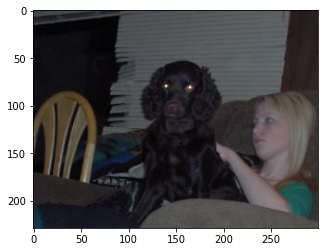

Name/breed: American water spaniel
Predicted:  Boykin spaniel
----------------------------------


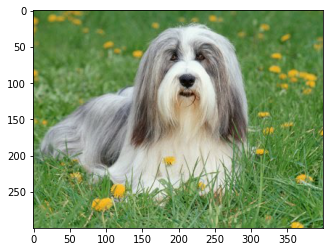

Name/breed: Bearded collie
Predicted:  Bearded collie
----------------------------------


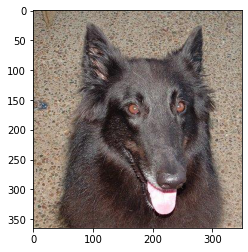

Name/breed: Belgian sheepdog
Predicted:  Belgian sheepdog
----------------------------------


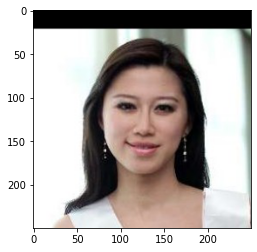

Name/breed: Szu Yu Chen
Predicted:  English toy spaniel
----------------------------------


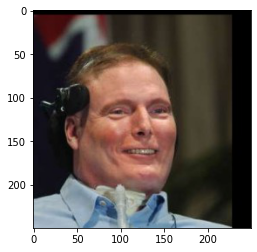

Name/breed: Christopher Reeve
Predicted:  Ibizan hound
----------------------------------


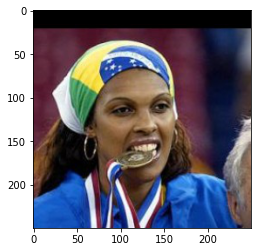

Name/breed: Kelly Santos
Predicted:  Australian shepherd
----------------------------------


In [ ]:
from random import randint

# prediction test on dog files
for i in range(3):
    test_img = dog_files_test[randint(0,len(dog_files_test))]
    pred_test = predict_breed_transfer(test_img)
    display_img_from_path(test_img, prediction=pred_test)

# prediction test on human files
for i in range(3):
    test_img = human_files[randint(0, len(human_files))]
    pred_test = predict_breed_transfer(test_img)
    display_img_from_path(test_img, prediction=pred_test)

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither

    # predict
    prediction = predict_breed_transfer(img_path)

    if face_detector(img_path):
        description = f'Hello, human!\nYou look like {prediction}.'
    elif dog_detector(img_path):
        description = f'Hi dog!\nYou seem to be {prediction}.'
    else:
        description = f'Hi there! I\'m affraid I cannot recognize you...\nbut you remind me of {prediction}.'
    
    display_img_from_path(img_path, title=False, descr=description)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

* The app may detect a dog as human. The face_detector performance is not perfect which was first noticed during initial test. Tested the run_app() performance with dog_detector first which seemed to improve. Finally reverted the change, as considered a potential risk with the app incorrectly detecting a human as a dog, which could lead to higher dissapointement of a potential user.
* As found in Step 0 the dataset is not ideal. It may consist dogs with humans, other dogs, dogs dressed. This dataset seems perfect for testing but have concerns that images for testing should be mroe carfully selected.
* The pretrianed model straight away achieved the requred threshold of 90% accuracy agains test dataset. There is potential to make few more adjustments to the model, or to try some changes in DataLoader section, as well as optimizer or loss function. 

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
# for file in np.hstack((human_files[:3], dog_files[:3])):
#     run_app(file)

test_files = np.array(glob("img_test/*"))
print(test_files)

['img_test/mj.jpg' 'img_test/ripley.jpg' 'img_test/cat.jpg'
 'img_test/dog_2.jpeg' 'img_test/dog_5.jpg' 'img_test/dog_6.jpg'
 'img_test/dog_3.jpg' 'img_test/dog_4.jpg' 'img_test/me.jpg'
 'img_test/dog_1.jpg' 'img_test/dog_drw.jpg']


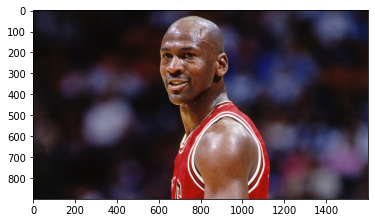

Hello, human!
You look like Golden retriever.
----------------------------------


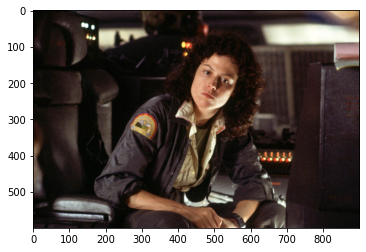

Hello, human!
You look like Alaskan malamute.
----------------------------------


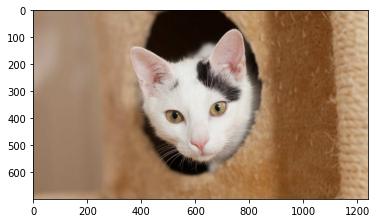

Hi there! I'm affraid I cannot recognize you...
but you remind me of Alaskan malamute.
----------------------------------


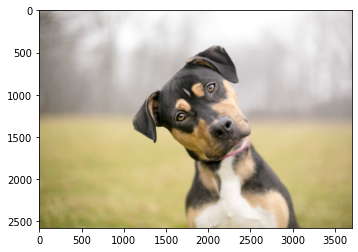

Hi dog!
You seem to be Entlebucher mountain dog.
----------------------------------


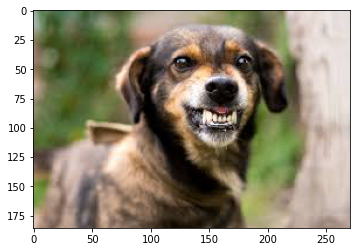

Hi dog!
You seem to be Anatolian shepherd dog.
----------------------------------


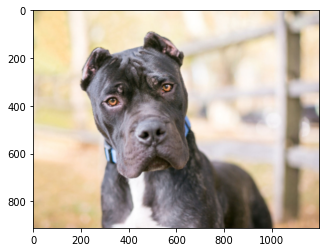

Hello, human!
You look like Cane corso.
----------------------------------


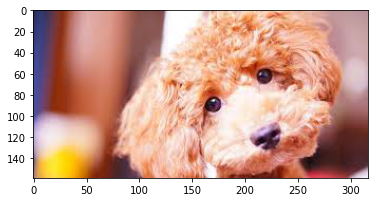

Hi dog!
You seem to be Bichon frise.
----------------------------------


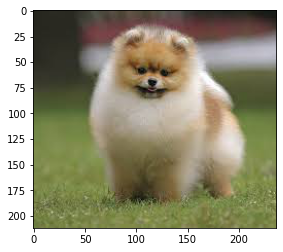

Hi dog!
You seem to be Pomeranian.
----------------------------------


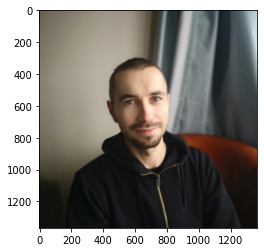

Hello, human!
You look like Italian greyhound.
----------------------------------


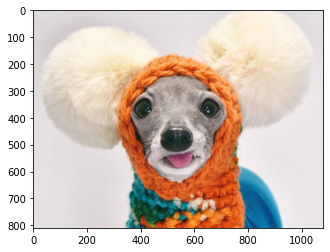

Hi dog!
You seem to be Poodle.
----------------------------------


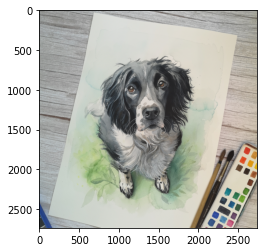

Hello, human!
You look like English setter.
----------------------------------


In [ ]:
for file in test_files:
    run_app(file)